In [1]:
%load_ext autoreload
%autoreload 2

In [125]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import wfdb
from wfdb import processing
import os
from functools import partial
from utils import plot_signal_with_r_peaks, load_patient
from tqdm import tqdm
import torch.nn as nn
from collections import Counter 

In [126]:
data_dir = 'mit-bih-arrhythmia'

In [128]:
# Set the path to store the downloaded data
data_dir = 'mit-bih-arrhythmia'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Download the data from the PhysioNet server
wfdb.dl_database(db_dir='mitdb', dl_dir=data_dir)

In [62]:
# rec_name = '100'
# record = wfdb.rdrecord(f'{data_dir}/{rec_name}')

In [100]:
# Read the downloaded data into memory
signals, fields = wfdb.rdsamp(f'{data_dir}/100')

# Print the signals and fields
print(signals)
print(fields)

[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


In [101]:
annotation = wfdb.rdann(f'{data_dir}/100', 'atr')
record = wfdb.rdrecord(f'{data_dir}/100')
print(f'Available labels that indicate types of cardiac events {set(annotation.symbol)}')

Available labels that indicate types of cardiac events {'A', '+', 'N', 'V'}


In [102]:
signals[:,0], record.p_signal[:,0]

(array([-0.145, -0.145, -0.145, ..., -0.675, -0.765, -1.28 ]),
 array([-0.145, -0.145, -0.145, ..., -0.675, -0.765, -1.28 ]))

In [103]:
def plot_signal_with_r_peaks(ecg, rpeaks, rec_name):
    '''
    Plot the ECG signal with R-peaks
    --------------------------------
    ecg: recodrd from x-laid 
    rpeaks: positions of peaks with types:
            'A' - Atrial premature beat
            '*' or 'N' - Normal beat
            'V' - Premature ventricular contraction 
    rec_name: record naming from data folder
    '''
    
    plt.figure(figsize=(20,10))
    
    plt.plot(ecg)
    plt.plot(rpeaks, ecg[rpeaks],'rx')
    plt.xlabel('Sample number')
    plt.ylabel('ECG signal')
    plt.title(f'ECG signal for record {rec_name} from MIT-BIH Arrhythmia Database')

In [124]:
record.fs

360

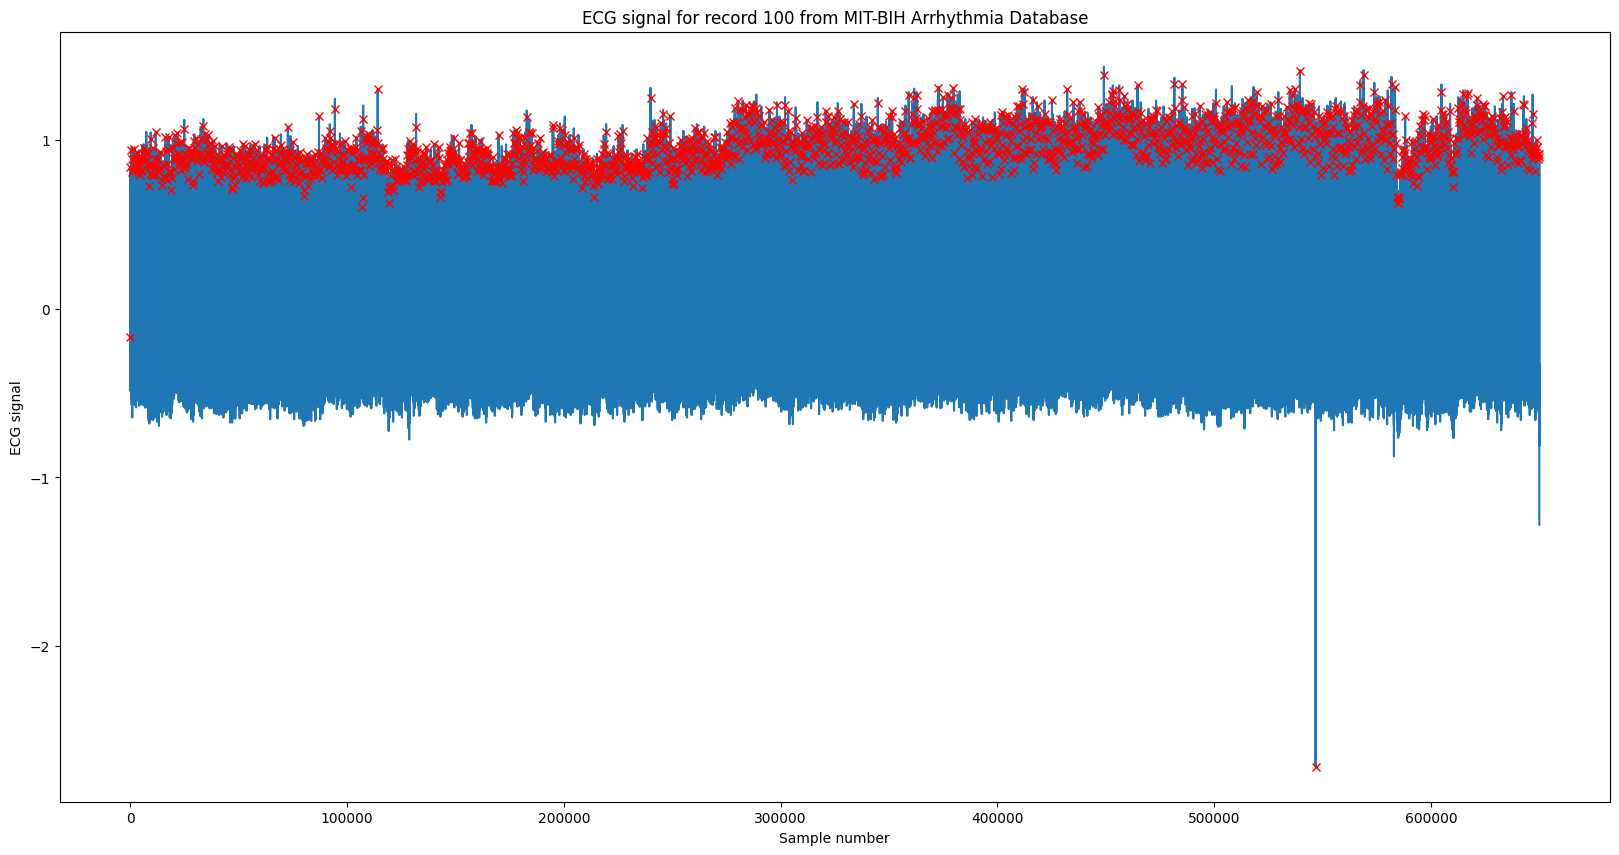

In [105]:
# Define R-peaks positions from annotation labels for Lead II 
Rpeaks_pos = annotation.sample[np.in1d(annotation.symbol, 
             ['+', 'A', 'N', 'V'])]

# Extract ECG signal
ecg = record.p_signal[:,0]

# Plot the ECG signal
plot_signal_with_r_peaks(ecg = record.p_signal[:,0], rpeaks = Rpeaks_pos, rec_name = rec_name)


In [31]:
# Load wcg signal with r-peaks labels 
ecg_101, Rpeaks_pos_101 = load_patient('mit-bih-arrhythmia', '101')

Loading Data for Patient : 101
Total Beats :  1864


In [106]:
# Window/Segment length 

l = 20 #seconds
# window stride for testing. 

s = 10 #seconds
# Sapmling frequency of ecg signal is 360 hz. 
# (https://archive.physionet.org/physiobank/database/html/mitdbdir/intro.htm#annotations)

fs = 360
# Window/Segment length in samples. 
win_size = l*fs
print(f"Window size is {win_size}")
# Stride for test window in samples. 
stride = s*fs

Window size is 7200


# Noise filtering 

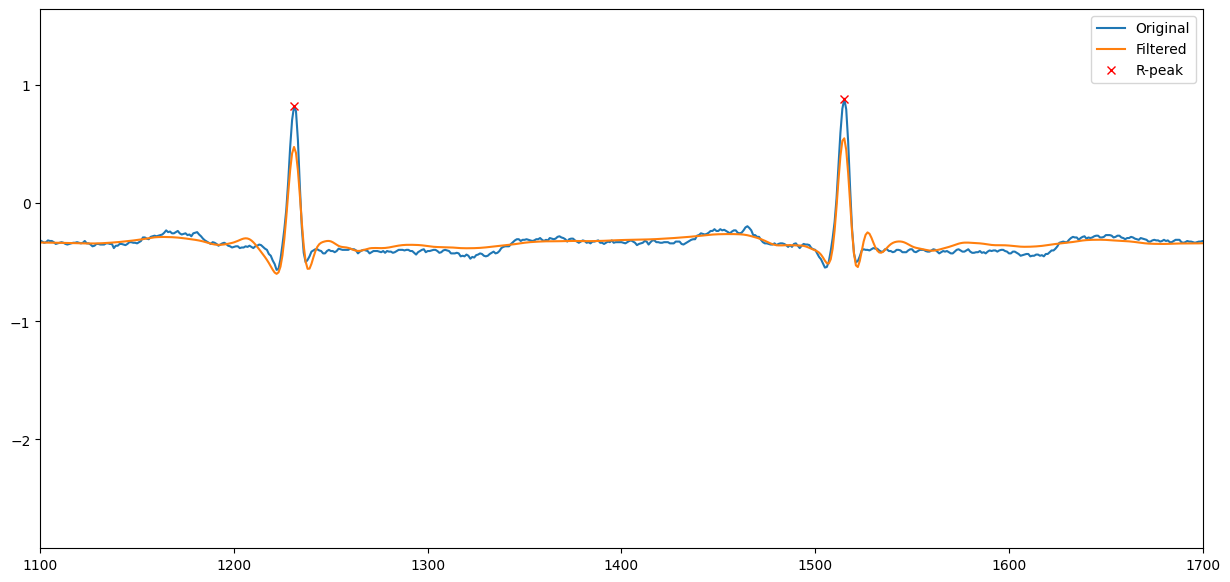

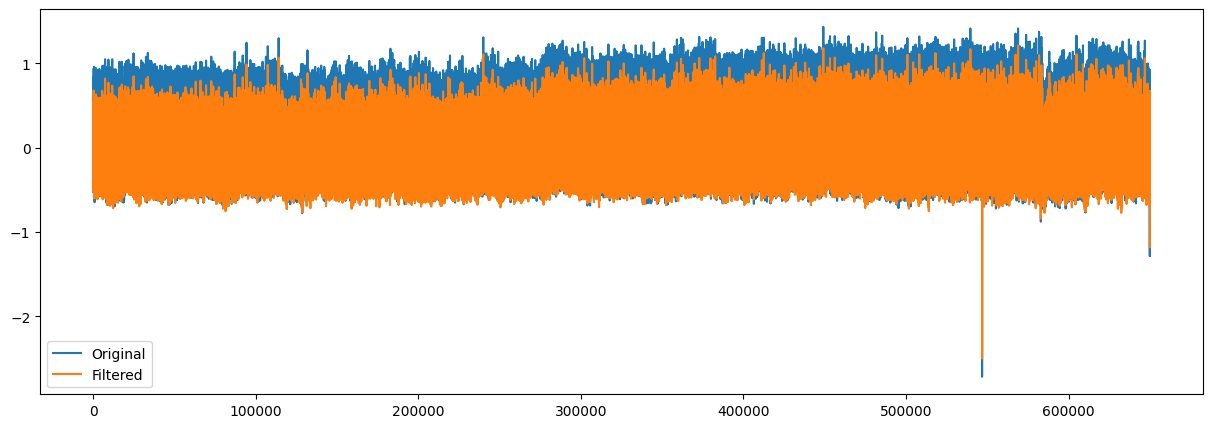

In [121]:
import wfdb
import numpy as np
import pywt
from scipy import signal as sig
import matplotlib.pyplot as plt


signal = ecg.flatten()

# Apply DWT
wavelet = 'db4'
level = 9
coeffs = pywt.wavedec(signal, wavelet, level=level)

# Remove baseline wandering
coeffs[1:] = [pywt.threshold(i, np.std(i)/2) for i in coeffs[1:]]
filtered_signal = pywt.waverec(coeffs, wavelet)

# Apply lowpass filter
nyquist = record.fs / 2
cutoff = 40
b, a = sig.butter(4, cutoff/nyquist, 'low')
filtered_signal = sig.filtfilt(b, a, filtered_signal)


plt.figure(figsize=(15, 7))
plt.plot(signal, label='Original')
plt.plot(filtered_signal, label='Filtered')
plt.plot(Rpeaks_pos, ecg[Rpeaks_pos],'rx', label = 'R-peak')
plt.xlim(1100, 1700)
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(signal, label='Original')
plt.plot(filtered_signal, label='Filtered')
plt.legend()
plt.show()



## Let's evaluate the filtering 
#### SNR is a measure of the ratio between the maximum possible power of a signal and the power of corrupting noise

In [93]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [123]:
# Adding noise for comparison 

noise_power = 0.1 * np.var(signal)
noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
noisy_signal = signal + noise

# Define DWT and lowpass filter parameters
wavelet = 'db4'
level = 9
nyquist = record.fs / 2
cutoff = 40

# Apply DWT and lowpass filter on the noisy signal
coeffs = pywt.wavedec(noisy_signal, wavelet, level=level)
coeffs[1:] = [pywt.threshold(i, np.std(i)/2) for i in coeffs[1:]]
filtered_signal = pywt.waverec(coeffs, wavelet)
b, a = sig.butter(4, cutoff/nyquist, 'low')
filtered_signal = sig.filtfilt(b, a, filtered_signal)

# Calculate SNR of the noisy and filtered signals
noise_power = np.var(noisy_signal - filtered_signal)
signal_power = np.var(filtered_signal)
snr_noisy = 10 * np.log10(signal_power / noise_power)
snr_filtered = 10 * np.log10(np.var(signal) / noise_power)

# Print SNR values
print('SNR of noisy signal: {:.2f} dB'.format(snr_noisy))
print('SNR of filtered signal: {:.2f} dB'.format(snr_filtered))

SNR of noisy signal: 5.30 dB
SNR of filtered signal: 7.32 dB


In [84]:
peak_signal_noise_ratio(signal, filtered_signal, data_range=np.max(signal) - np.min(signal))

36.91065969044453